### Plot data tracks (e.g., from ChIP-seq)

In [1]:
from __future__ import division
%pylab inline
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from scipy.signal import medfilt
import seaborn as sns
from Bio import SeqIO
import glob
sns.set_style('ticks')
sns.set_context('paper')

def parse_sist_melt(fn):
    """SIST melt file to numpy array"""
    data = []
    with open(fn,'r') as f:
        for line in f:
            line = line.strip()
            if 'Position' in line or 'WARNING' in line:
                continue
            line = line.split()
            line[0],line[1],line[2] = int(line[0])-1,float(line[1]),float(line[2])
            data.append(line[1])
    return np.array(data)

def parse_sist_cruciform(fn):
    """SIST cruciform file to numpy array"""
    data = []
    with open(fn,'r') as f:
        for line in f:
            line = line.strip()
            if 'Position' in line or 'WARNING' in line:
                continue
            line = line.split()
            line[0],line[1] = int(line[0])-1,float(line[1])
            data.append(line[1])
    return np.array(data)

def stitch_sist(fns,dtype='melt',maxe = 200000):
    """Stitch together a SIST file based in information contained in
    the filename:
    # Example fn format: II_1603582-1643583_0.algM.txt
    """
    
    data = None
    for fn in fns:
        fn_split = fn.split('_')        
        fn_split[-1] = fn_split[-1].split('.')[0]        
        offset = int(fn_split[-1])
        
        try:
            [s,e] = fn_split[-2].split('-')
            s,e = int(s),int(e)
        except:
            s = 0
            e = maxe
        n = e-s+1
        
        if data is None:
            data = np.zeros(n)
        
        if dtype=='melt':
            sdata = parse_sist_melt(fn)
        else:
            sdata = parse_sist_cruciform(fn)
        data[offset:offset+len(sdata)] = np.maximum(sdata,data[offset:offset+len(sdata)])
        
    return data

def movingaverage (values, window):
    """Compute the moving average for a specified window width"""
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

def major_formatter(x,pos):
    xs = np.floor(np.log(abs(x)+1))
    if xs <= 2:
        xs = 0
    elif xs >= 3 and xs < 6:
        xs = 2
    elif xs >= 6:
        xs = 5
    return "%.1f" % (x/(10**xs))

def format_fill_axis(ax,data,xvals=None,xlim=None,ylim=None,xlabel=None,
             ylabel=None,xticks=None,yticks=None,xticklabels=None,
             yticklabels=None,ticklen=5,color='black',pos=''):
    
    """Format an axis object to produce a filled in ChIP-seq track;
    specifiy pos='bottom' to create the bottom-most track, which contains
    the x-axis"""
    
    if xvals is None:
        xvals = np.arange(len(data))
    ax.fill_between(xvals,data,0,facecolor=color,lw=1,edgecolor=color,rasterized=True)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    else:
        ax.set_xlim(np.min(xvals),np.max(xvals))
    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim(np.min(data),np.max(data))
        
    if xticks is not None and xticklabels is not None:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
    else:
        ax.xaxis.set_major_locator(ticker.AutoLocator())
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
        
    setp(ax.get_yticklabels(),fontsize=10)
    ax.tick_params('y',length=ticklen)       
        
    if pos != 'bottom':
        setp(ax.get_xticklabels(),visible=False)
        ax.tick_params('x',length=0)
    else:   
        setp(ax.get_xticklabels(),fontsize=10)
        ax.tick_params('x',length=ticklen)
        if xlabel is not None:
            ax.set_xlabel(xlabel,size=10)
    
    if ylabel is not None:
        ax.set_ylabel(ylabel,rotation=0,size=12,ha='right')
        ax.yaxis.set_label_coords(-0.2,0.25)
    if yticks is not None:
        ax.set_yticks(yticks)
    else:
        ax.yaxis.set_major_locator(ticker.MaxNLocator(3,prune=None))
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels)
    
    if pos != 'bottom':
        sns.despine(ax=ax,bottom=True,trim=False)
    else:
        sns.despine(ax=ax,trim=False)    
    ax.xaxis.offsetText.set_visible(False)

def format_img_axis(ax,data,xlabel=None,ylabel=None,xticks=None,colormap=None,ticklen=5,pos='mid'):
    ax.imshow(data.reshape(1,len(data)),aspect='auto',cmap=colormap,rasterized=True)
    ax.set_yticks([])
    if pos != 'bottom':
        ax.tick_params('x',size=0)
        setp(ax.get_xticklabels(), visible=False)
    else:
        if xticks is None:
            ax.xaxis.set_major_locator(ticker.AutoLocator())
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(major_formatter))
        else:
            ax.set_xticks(xticks)
        ax.tick_params('x',size=ticklen)
        if xlabel is not None:
            ax.set_xlabel(xlabel,size=10)
        setp(ax.get_xticklabels(),fontsize=10)
    if ylabel is not None:
        ax.set_ylabel(ylabel,rotation=0,size=12,ha='right')
        ax.yaxis.set_label_coords(-0.2,0)
    setp(ax.get_yticklabels(),fontsize=10)
    ax.xaxis.offsetText.set_visible(False)
            
    
        
def bed2arr(fn,mine,maxe,ignorescore=False,chrom=None):
    arr = np.zeros(maxe-mine+1)
    
    with open(fn,'r') as f:
        for line in f:
            line = line.strip().split()
                        
            if chrom is not None and line[0] != chrom:
                continue
            try:
                line[1],line[2],line[3] = int(line[1]),int(line[2]),float(line[3])
                incr = float(line[3])
            except:
                line[1],line[2] = int(line[1]),int(line[2])
                incr = 1
            s = line[1]-mine
            e = line[2]-mine+1
            arr[s:e] += incr            
    return arr



def properbed2arr(fn,mine,maxe,chrom=None,useScore=False):
    arr = np.zeros(maxe-mine+1)
    
    with open(fn,'r') as f:
        for line in f:
            line = line.strip().split()
            if chrom is not None and line[0] != chrom:
                continue
            
            line[1],line[2],line[4] = int(line[1]),int(line[2]),float(line[4])
            s = line[1]-mine
            e = line[2]-mine+1
            
            if (s < 0 or e >= len(arr)):
                continue
            
            if (useScore):
                arr[s:e] = np.maximum(arr[s:e],line[4])
            else:
                arr[s:e] += 1
            
    return arr

def read_bed_coords(fn):
    coords = []
    with open(fn,'r') as f:
        for line in f:
            line = line.strip().split()
            line[1],line[2] = int(line[1]),int(line[2])
            coords.append((line[0],line[1],line[2]))
    return coords

Populating the interactive namespace from numpy and matplotlib


#### Chicken

In [2]:
chrom='chr5'
s=3007475
e=3087475

cenpa = bed2arr('../data/tracks/dt40.cenpa.avg.bed',mine=s,maxe=e,chrom=chrom,ignorescore=True)
melt = stitch_sist(glob.glob('../data/tracks/chicken.cen.unique.mid.win40000/'+chrom+'*algM.txt'),'melt')
cruc = stitch_sist(glob.glob('../data/tracks/chicken.cen.unique.mid.win40000/'+chrom+'*algC.txt'),'cruc')
g = glob.glob('../data/palindrome/chicken/unique_cen/'+chrom+'*emboss.bed')
dyads = bed2arr(g[0],0,e-s,ignorescore=False)
    

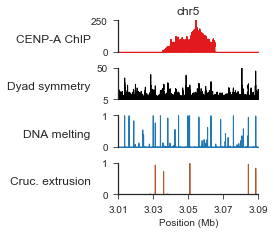

In [4]:
xts = np.linspace(0,e-s+1,5)
plt.figure(figsize=(2.5,3.2))
G = gridspec.GridSpec(4,1,height_ratios=[0.5,0.5,0.5,0.5],hspace=0.5)

ax1 = plt.subplot(G[0,:])
format_fill_axis(ax1,cenpa,ylabel='CENP-A ChIP',ylim=[0,25000],yticklabels=[0,250],yticks=[0,25000],color='#e31a1c',
                xticks=xts)

ax2 = plt.subplot(G[1,:],sharex = ax1)
format_fill_axis(ax2,dyads,ylabel='Dyad symmetry',ylim=[5,50],yticklabels=[5,50],yticks=[5,50],color='black')

ax3 = plt.subplot(G[2,:],sharex = ax1)
format_fill_axis(ax3,melt,ylabel='DNA melting',ylim=[0,1],yticklabels=[0,1],yticks=[0,1],color='#1f78b4')

ax4 = plt.subplot(G[3,:],sharex = ax1)
format_fill_axis(ax4,cruc,ylabel='Cruc. extrusion',ylim=[0,1],yticklabels=[0,1],yticks=[0,1],color='#b15928',
                 pos='bottom',xlabel='Position (Mb)',xticks=xts)
    
newlabels = ["%.2f" % ((s+x)/1000000) for x in xts]

ax4.set_xticklabels(newlabels)
ax1.set_title('chr5',size=12)
plt.savefig('../figures/chicken_cen5.svg',dpi=300)

#### Mouse

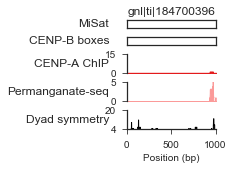

In [19]:
chrom='gnl|ti|184700396'
s=0
e=1007

# chrom='gnl|ti|71556253'
# s=0
# e=1012

# chrom ='gnl|ti|19360812'
# s =0 
# e=1060

rname = chrom.replace('|','_')

cenpa = bed2arr('../data/tracks/misat.per_base.cvg',mine=s,maxe=e,chrom=chrom,ignorescore=False)
misat = properbed2arr('../data/tracks/misat.118-122.1kb.misat.blast.bed',s,e,chrom=chrom,useScore=False)
misat = misat >= 1
cenpb = properbed2arr('../data/tracks/misat_118-122.1kb.cenp_b.fimo.bed',s,e,chrom=chrom,useScore=False)
cenpb = cenpb >=1
ssdna_activ = bed2arr('../data/tracks/misat.ssdna_activ.cvg',mine=s,maxe=e,chrom=chrom,ignorescore=False)
ssdna_control = bed2arr('../data/tracks/misat.ssdna_control.cvg',mine=s,maxe=e,chrom=chrom,ignorescore=False)

ssdna = np.log2(ssdna_activ+1) - np.log2(ssdna_control+1)

g = glob.glob('../data/palindrome/mouse/'+rname+'*emboss.bed')
dyads = bed2arr(g[0],0,e-s+1,ignorescore=False)
    
xts = np.linspace(0,1000,5)

plt.figure(figsize=(1.6,2))
G = gridspec.GridSpec(5,1,height_ratios=[0.2,0.2,0.5,0.5,0.5],hspace=0.6)

ax1 = plt.subplot(G[0,:])
format_img_axis(ax1,misat,colormap=cm.binary,ylabel='MiSat')

ax2 = plt.subplot(G[1,:],sharex=ax1)
format_img_axis(ax2,cenpb,colormap=cm.binary,ylabel='CENP-B boxes')

ax3 = plt.subplot(G[2,:],sharex=ax1)
format_fill_axis(ax3,np.log(cenpa+1),ylabel='CENP-A ChIP',ylim=[0,15],yticklabels=[0,15],yticks=[0,15],color='#e31a1c')

ax4 = plt.subplot(G[3,:],sharex=ax1)
format_fill_axis(ax4,ssdna,ylabel='Permanganate-seq',ylim=[0,5],yticklabels=[0,5],yticks=[0,5],color='#fb9a99',
                xlabel='Position (bp)')

ax5 = plt.subplot(G[4,:],sharex=ax1)
format_fill_axis(ax5,dyads,ylabel='Dyad symmetry',xlim=[0,e],ylim=[4,20],yticklabels=[4,20],yticks=[4,20],color='black',
                xlabel='Position (bp)', pos='bottom')

ax1.set_title(chrom,size=12)
plt.savefig('../figures/mouse'+rname+'.svg',dpi=300)

#### Pombe

In [17]:
coords = [('I',3736553,3806554),('II',1588582,1658583),('III',1068953,1138954)]
N = len(coords)

cenpa_mu = None
melt_mu = None
cruc_mu = None
dyad_mu = None
for chrom,s,e in coords:
    cenpa = bed2arr('../data/tracks/cnp1.pombe.cov.bed',mine=s,maxe=e,chrom=chrom)
    melt = stitch_sist(glob.glob('../data/tracks/pombe.cen.mid.win70k_sist/'+chrom+'_'+str(s)+'-*algM.txt'),'melt')
    cruc = stitch_sist(glob.glob('../data/tracks/pombe.cen.mid.win70k_sist/'+chrom+'_'+str(s)+'-*algC.txt'),'cruc')
    dyads = bed2arr('../data/palindrome/pombe/pombe_cen/'+chrom+'_'+str(s)+'_'+str(e)+'.emboss.bed',0,e-s,ignorescore=False)
    
    if cenpa_mu is None:
        cenpa_mu = cenpa
        melt_mu = melt
        cruc_mu = cruc
        dyad_mu = dyads
    else:
        cenpa_mu += cenpa
        melt_mu += melt
        cruc_mu += cruc
        dyad_mu += dyads
        
cenpa_mu/=N
melt_mu/=N
cruc_mu/=N
dyad_mu/=N

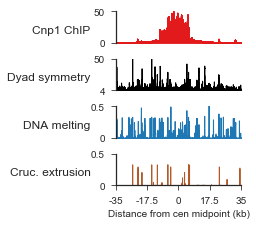

In [18]:
plt.figure(figsize=(2.25,3.2))
G = gridspec.GridSpec(4,1,height_ratios=[0.5,0.5,0.5,0.5],hspace=0.5)

xts = [0,17500,35000,52500,70000]
labs = [-35,-17.5,0,17.5,35]

ax1 = plt.subplot(G[0,:])
format_fill_axis(ax1,cenpa_mu,ylabel='Cnp1 ChIP',ylim=[0,50000],yticklabels=[0,50],yticks=[0,50000],color='#e31a1c'
                ,xticks=xts,xticklabels=labs)

ax2 = plt.subplot(G[1,:],sharex=ax1)
format_fill_axis(ax2,dyad_mu,ylabel='Dyad symmetry',ylim=[4,50],yticklabels=[4,50],yticks=[4,50],color='black')

ax3 = plt.subplot(G[2,:],sharex=ax1)
format_fill_axis(ax3,melt_mu,ylabel='DNA melting',ylim=[0,0.5],yticklabels=[0,0.5],yticks=[0,0.5],color='#1f78b4')

ax4 = plt.subplot(G[3,:],sharex=ax1)
format_fill_axis(ax4,cruc_mu,ylabel='Cruc. extrusion',ylim=[0,0.5],yticklabels=[0,0.5],yticks=[0,0.5],color='#b15928',
                pos='bottom',xticks=xts,xticklabels=labs,xlabel=('Distance from cen midpoint (kb)'))
ax4.set_xticklabels(labs)

plt.savefig('../figures/pombe_cen_avg.svg',dpi=300)


#### S. cerevisiae

In [13]:
cse4_mu = np.zeros(2002)
dyad_mu = np.zeros(2002)
ssdna_mu = np.zeros(2001)
cruc_mu = np.zeros(2001)

coords = read_bed_coords('../data/yeast/sist/sacCer2.cen.mid.win.1kb.bed')


for c in coords:
    
    ch,s,e = c[0],c[1],c[2]
    
    cse4_mu += bed2arr('../data/yeast/cse4_krassovsky.cov.bed',s,e,chrom=ch)
    
    
    palfn = '../data/yeast/emboss/'+ch+'.sc2.palindrome.min5.max100.gap10.mismatch0.ovl.bedgraph'
    dyad_mu += bed2arr(palfn,s,e,ignorescore=False,chrom=ch)    
    
    ssdna_mu += parse_sist_melt('../data/yeast/sist/sc2.'+ch+'.algM.txt')
    cruc_mu += parse_sist_cruciform('../data/yeast/sist/sc2.'+ch+'.algC.txt')
    
                           
cse4_mu /= len(coords)
dyad_mu /= len(coords)
ssdna_mu /= len(coords)
ssdna_mu /= len(coords)

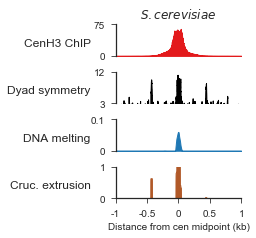

In [15]:
plt.figure(figsize=(2.25,3.2))
G = gridspec.GridSpec(4,1,height_ratios=[0.5,0.5,0.5,0.5],hspace=0.5)

xts = [0,500,1000,1500,2000]
labs = [-1,-0.5,0,0.5,1]

ax1 = plt.subplot(G[0,:])
format_fill_axis(ax1,cse4_mu,ylabel='CenH3 ChIP',ylim=[0,75000],yticklabels=[0,75],yticks=[0,75000],color='#e31a1c'
                ,xticks=xts,xticklabels=labs)

ax2 = plt.subplot(G[1,:],sharex=ax1)
format_fill_axis(ax2,dyad_mu,ylabel='Dyad symmetry',ylim=[3,12],yticklabels=[3,12],yticks=[3,12],color='black')

ax3 = plt.subplot(G[2,:],sharex=ax1)
format_fill_axis(ax3,ssdna_mu,ylabel='DNA melting',ylim=[0,0.1],yticklabels=[0,0.1],yticks=[0,0.1],color='#1f78b4')

ax4 = plt.subplot(G[3,:],sharex=ax1)
format_fill_axis(ax4,cruc_mu,ylabel='Cruc. extrusion',ylim=[0,1],yticklabels=[0,1],yticks=[0,1],color='#b15928',
                pos='bottom',xticks=xts,xticklabels=labs,xlabel=('Distance from cen midpoint (kb)'))
ax4.set_xticklabels(labs)

ax1.set_title(r'$\it{S. cerevisiae}$',size=12)
plt.savefig('../figures/sc2_average.svg',dpi=300)



#### Human neocen

In [4]:
chrom='chr4'
s = 88100000
e = 88600000
cenpa = bed2arr('../data/tracks/neocen/chr4.pdcn4_cenpa.cov.bed',s,e)
pal = bed2arr('../data/tracks/neocen/PDNC4.emboss.bed',0,e-s,ignorescore=True)
gapf = bed2arr('../data/tracks/neocen/chr4.gapf.cov.bed',s,e)
melt = stitch_sist(glob.glob('../data/human_neocen_sist/'+chrom+'_*algM.txt'),'melt')[50000:-50001]
cruc = stitch_sist(glob.glob('../data/human_neocen_sist/'+chrom+'_*algC.txt'),'cruc')[50000:-50001]

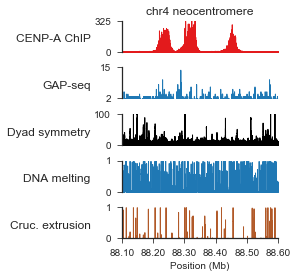

In [10]:

plt.figure(figsize=(2.8,4))
G = gridspec.GridSpec(5,1,height_ratios=[0.5,0.5,0.5,0.5,0.5],hspace=0.5)

ax1 = plt.subplot(G[0,:])
format_fill_axis(ax1,cenpa,xvals=np.arange(s,e+1),ylabel='CENP-A ChIP',color='#e31a1c',ylim=[0,325],yticks=[0,325])

ax2 = plt.subplot(G[1,:],sharex=ax1)
format_fill_axis(ax2,gapf,xvals=np.arange(s,e+1),ylabel='GAP-seq',color='#1f78b4',ylim=[2,15],yticks=[2,15])

ax3 = plt.subplot(G[2,:],sharex=ax1)
format_fill_axis(ax3,pal,xvals=np.arange(s,e+1),ylabel='Dyad symmetry',color='black',ylim=[0,100],yticks=[0,100])

ax4 = plt.subplot(G[3,:],sharex=ax1)
format_fill_axis(ax4,melt,xvals=np.arange(s,e+1),ylabel='DNA melting',color='#1f78b4',ylim=[0,1],yticks=[0,1])

ax5 = plt.subplot(G[4,:],sharex=ax1)
format_fill_axis(ax5,cruc,xvals=np.arange(s,e+1),ylabel='Cruc. extrusion',color='#b15928',ylim=[0,1],yticks=[0,1],pos='bottom',
                xlabel = 'Position (Mb)')

newlabels = ["%.2f" % ((x)/1000000) for x in ax3.get_xticks()]

ax4.set_xticklabels(newlabels)

ax1.set_title('chr4 neocentromere',size=12)
plt.savefig('../figures/chr4neocen.svg',dpi=300)

In [89]:
chrom='chr13'
s = 97650000
e = 97850000
cenpa = bed2arr('../data/neocen/chr13.ims13q_cenpa.cov.bed',s,e)
pal = bed2arr('../data/neocen/IMS13q.emboss.bed',0,e-s,ignorescore=True)
gapf = bed2arr('../data/neocen/chr13.gapf.cov.bed',s,e)
melt = stitch_sist(glob.glob('../data/human_neocen_sist/'+chrom+'_*algM.txt'),'melt')[200000:-200001]
cruc = stitch_sist(glob.glob('../data/human_neocen_sist/'+chrom+'_*algC.txt'),'cruc')[200000:-200001]

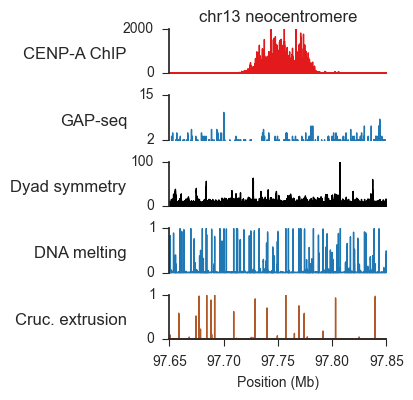

In [90]:

plt.figure(figsize=(2.8,4))
G = gridspec.GridSpec(5,1,height_ratios=[0.5,0.5,0.5,0.5,0.5],hspace=0.5)

ax1 = plt.subplot(G[0,:])
format_fill_axis(ax1,cenpa,xvals=np.arange(s,e+1),ylabel='CENP-A ChIP',color='#e31a1c',ylim=[0,2000],yticks=[0,2000])

ax2 = plt.subplot(G[1,:],sharex=ax1)
format_fill_axis(ax2,gapf,xvals=np.arange(s,e+1),ylabel='GAP-seq',color='#1f78b4',ylim=[2,15],yticks=[2,15])

ax3 = plt.subplot(G[2,:],sharex=ax1)
format_fill_axis(ax3,pal,xvals=np.arange(s,e+1),ylabel='Dyad symmetry',color='black',ylim=[0,100],yticks=[0,100])

ax4 = plt.subplot(G[3,:],sharex=ax1)
format_fill_axis(ax4,melt,xvals=np.arange(s,e+1),ylabel='DNA melting',color='#1f78b4',ylim=[0,1],yticks=[0,1])

ax5 = plt.subplot(G[4,:],sharex=ax1)
format_fill_axis(ax5,cruc,xvals=np.arange(s,e+1),ylabel='Cruc. extrusion',color='#b15928',ylim=[0,1],yticks=[0,1],pos='bottom',
                xlabel = 'Position (Mb)')

newlabels = ["%.2f" % ((x)/1000000) for x in ax3.get_xticks()]

ax4.set_xticklabels(newlabels)

ax1.set_title('chr13 neocentromere',size=12)
plt.savefig('../figures/chr13neocen.svg',dpi=300)

In [83]:
chrom='chr8'
s = 86400000
e = 87000000
cenpa = bed2arr('../data/neocen/chr8.ims13q_cenpa.cov.bed',s,e)
pal = bed2arr('../data/neocen/MS4221q.emboss.bed',0,e-s,ignorescore=True)
gapf = bed2arr('../data/neocen/chr8.gapf.cov.bed',s,e)
melt = stitch_sist(glob.glob('../data/human_neocen_sist/'+chrom+'_*algM.txt'),'melt')[:-1]
cruc = stitch_sist(glob.glob('../data/human_neocen_sist/'+chrom+'_*algC.txt'),'cruc')[:-1]

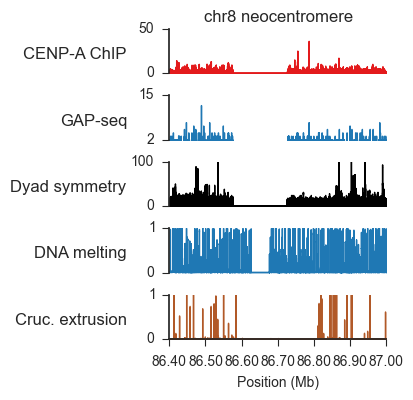

In [88]:

plt.figure(figsize=(2.8,4))
G = gridspec.GridSpec(5,1,height_ratios=[0.5,0.5,0.5,0.5,0.5],hspace=0.5)

ax1 = plt.subplot(G[0,:])
format_fill_axis(ax1,cenpa,xvals=np.arange(s,e+1),ylabel='CENP-A ChIP',color='#e31a1c',ylim=[0,50],yticks=[0,50])

ax2 = plt.subplot(G[1,:],sharex=ax1)
format_fill_axis(ax2,gapf,xvals=np.arange(s,e+1),ylabel='GAP-seq',color='#1f78b4',ylim=[2,15],yticks=[2,15])

ax3 = plt.subplot(G[2,:],sharex=ax1)
format_fill_axis(ax3,pal,xvals=np.arange(s,e+1),ylabel='Dyad symmetry',color='black',ylim=[0,100],yticks=[0,100])

ax4 = plt.subplot(G[3,:],sharex=ax1)
format_fill_axis(ax4,melt,xvals=np.arange(s,e+1),ylabel='DNA melting',color='#1f78b4',ylim=[0,1],yticks=[0,1])

ax5 = plt.subplot(G[4,:],sharex=ax1)
format_fill_axis(ax5,cruc,xvals=np.arange(s,e+1),ylabel='Cruc. extrusion',color='#b15928',ylim=[0,1],yticks=[0,1],pos='bottom',
                xlabel = 'Position (Mb)')

newlabels = ["%.2f" % ((x)/1000000) for x in ax3.get_xticks()]

ax4.set_xticklabels(newlabels)

ax1.set_title('chr8 neocentromere',size=12)
plt.savefig('../figures/chr8neocen.svg',dpi=300)

#### Chicken neocen

In [29]:
chrom,s,e = 'chrZ',3770000,3820000

cenpa = bed2arr('../data/tracks/bm23.cenpa.neocen.avg.bed',mine=s,maxe=e,chrom=chrom,ignorescore=True)
melt = stitch_sist(glob.glob('../data/tracks/chicken.neocen.sist/*algM.txt'),'melt')
cruc = stitch_sist(glob.glob('../data/tracks/chicken.neocen.sist/*algC.txt'),'cruc')
g = glob.glob('../data/tracks/chicken_palindrome/neocen/'+chrom+'*.emboss.bed')
dyads = bed2arr(g[0],0,e-s,ignorescore=False)

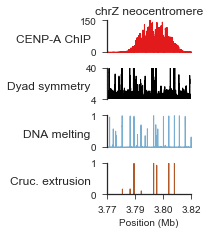

In [33]:

plt.figure(figsize=(1.5,3.2))
G = gridspec.GridSpec(4,1,height_ratios=[0.5,0.5,0.5,0.5],hspace=0.5)

xv = np.arange(s,e+1)

ax1 = plt.subplot(G[0,:])
format_fill_axis(ax1,cenpa,xvals=xv,ylabel='CENP-A ChIP',color='#e31a1c',ylim=[0,15000],yticks=[0,15000],
                 yticklabels=[0,150],xlim=(s,e),xticks=[s,e])

ax2 = plt.subplot(G[1,:],sharex=ax1)
format_fill_axis(ax2,dyads,xvals=xv,ylabel='Dyad symmetry',color='black',ylim=[4,40],yticks=[4,49],yticklabels=[4,40])

ax3 = plt.subplot(G[2,:],sharex=ax1)
format_fill_axis(ax3,melt,xvals=xv,ylabel='DNA melting',color='#78aed2',ylim=[0,1],yticks=[0,1],yticklabels=[0,1])

ax4 = plt.subplot(G[3,:],sharex=ax1)
format_fill_axis(ax4,cruc,xvals=xv,ylabel='Cruc. extrusion',color='#b15928',ylim=[0,1],yticks=[0,1],yticklabels=[0,1],
                 pos='bottom',xlabel = 'Position (Mb)',xlim=[s,e],xticks=[s,e])

# newlabels = ["%.2f" % ((x)/1000000) for x in ax4.get_xticks()]

# ax4.set_xticklabels(newlabels)
ax4.set_xticks(np.linspace(s,e+1,4))
ax4.set_xticklabels(["%.2f" %z for z in np.linspace(s,e+1,4)/1000000])



ax1.set_title('chrZ neocentromere',size=12)
plt.savefig('../figures/chicken_cenZ.svg',dpi=300)

#### BACs

In [4]:
# chrom='chrUnplaced_BAC2'
# s,e = 0,3921
# chrom = 'D5Z2'
# chrom = 'D7Z2'
# s,e = 0,6205
# chrom = 'D5Z1'
s,e = 0,6295


chrom = 'DYZ3'
s,e = 0,6205
asat = properbed2arr('../data/tracks/6kb_BACs.alphoid.bed',s,e,chrom=chrom,useScore=False)
# asat = asat.reshape((1,len(asat)))
boxes = properbed2arr('../data/tracks/6kb_BACs.cenp_b.fimo.bed',s,e,chrom=chrom,useScore=False)
# boxes = boxes.reshape((1,len(boxes)))

cenpa = bed2arr('../data/tracks/huref_cenpa.bacs.cov.bed',s,e,chrom=chrom)
ssdna = bed2arr('../data/tracks/raji_ssdna.bacs.cov.5p.bed',s,e,chrom=chrom)
ssdna_s = movingaverage(ssdna,100)

dyad = bed2arr('../data/palindrome/bacs_palindrome/'+chrom+'_0_'+str(e)+'.emboss.bed',s,e,ignorescore=False)
dyad_s = medfilt(dyad,5)
melt = parse_sist_melt('../data/6kb_BACs_sist/'+chrom+'.algM.txt')
cruc = parse_sist_cruciform('../data/6kb_BACs_sist/'+chrom+'.algC.txt')

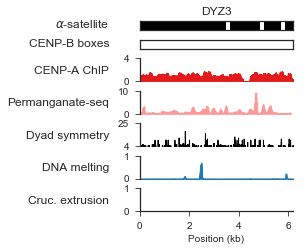

In [18]:
plt.figure(figsize=(2.75,3.5))
G = gridspec.GridSpec(7,1,height_ratios=[0.2,0.2,0.5,0.5,0.5,0.5,0.5],hspace=0.5)

ax1 = plt.subplot(G[0,:])
format_img_axis(ax1,asat>0,ylabel=r'$\alpha$'+'-satellite')

ax2 = plt.subplot(G[1,:],sharex=ax1)
format_img_axis(ax2,boxes>0,ylabel='CENP-B boxes')

ax3 = plt.subplot(G[2,:],sharex = ax1)
# format_fill_axis(ax3,cenpa,color='#e31a1c',ylabel='CENP-A ChIP',ylim=[0,500000],yticks=[0,500000],yticklabels=[0,50])
# format_fill_axis(ax3,cenpa,color='#e31a1c',ylabel='CENP-A ChIP',ylim=[0,10000],yticks=[0,10000],yticklabels=[0,1])
format_fill_axis(ax3,cenpa,color='#e31a1c',ylabel='CENP-A ChIP',ylim=[0,40000],yticks=[0,40000],yticklabels=[0,4])

ax4 = plt.subplot(G[3,:],sharex = ax1)
# format_fill_axis(ax4,ssdna_s,color='#fb9a99',ylabel='Permanganate-seq',ylim=[0,1000],yticks=[0,1000],yticklabels=[0,10])

# DYZ3
# format_fill_axis(ax4,ssdna_s,color='#fb9a99',ylabel='Permanganate-seq',ylim=[0,400],yticks=[0,400],yticklabels=[0,10])

ax5 = plt.subplot(G[4,:],sharex=ax1)
format_fill_axis(ax5,dyad_s,color='black',ylabel='Dyad symmetry',ylim=[4,25],yticks=[4,25])

ax6 = plt.subplot(G[5,:],sharex=ax1)
format_fill_axis(ax6,melt,color='#1f78b4',ylabel='DNA melting',ylim=[0,1],yticks=[0,1])

ax7 = plt.subplot(G[6,:],sharex=ax1)
format_fill_axis(ax7,cruc,color='#b15928',ylabel='Cruc. extrusion',ylim=[0,1],yticks=[0,1],pos='bottom',xlabel='Position (kb)')
ax7.set_xticklabels((ax6.get_xticks()/1000).astype(int))

ax1.set_title(chrom,size=12)
plt.savefig('../figures/'+chrom+'.svg',dpi=300)